EDITED THE FOLLOWING CELLS:



# IMPORTS

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from imgaug import augmenters as iaa
import albumentations as A
import torch
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/DePondFi/Copy of Copy of DePondFi'24_Train.zip"

Archive:  /content/drive/MyDrive/DePondFi/Copy of Copy of DePondFi'24_Train.zip
   creating: DePoondF'i24_Train/Images/
  inflating: DePoondF'i24_Train/Images/frame_0003_jpg.rf.0263105ec77d2e2da055592023b9c365.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0004_jpg.rf.f21cc7af2807703eabb7929ebf6058cf.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0011_jpg.rf.2102209f6271db8d86e16e3598032180.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0012_jpg.rf.b3b8d851f0553337b709eed85868691b.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0013_jpg.rf.afec6e42f9e709fdaa1579ea9c0a78e1.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0013_jpg.rf.fc41e3ace2f43863502ea96bf381b92f.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0014_jpg.rf.21a2330d216a07e1808bbc667fb511b9.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0016_jpg.rf.442421a9b5f27ac9a8711de49b29d668.jpg  
  inflating: DePoondF'i24_Train/Images/frame_0017_jpg.rf.6b7084a5df8a612cfcf0488e246c8647.jpg  
  inflating: DeP

# Sample Code

In [8]:
import os
import numpy as np
import cv2
import argparse
from tqdm import tqdm

def read_files_from_folder(folder_path, filename):
    file_data = []
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r') as file:
        for line in file:
            values = list(map(float, line.replace("\n", "").split(",")))
            file_data.append(values)
    return np.array(file_data)

def process_images_and_keypoints(image_path, keypoint_path):
    # Check if output directories exist, create them if they do not
    output_files = "./converted_files/"

    if not os.path.exists(output_files):
        os.makedirs(output_files)

    txt_filename = os.listdir(keypoint_path)

    transformed_coord = np.zeros((len(txt_filename), 198))
    coordinate_shape = []

    transformed_images = np.zeros((len(txt_filename), 224, 224, 3))

    for i in tqdm(range(len(txt_filename))):
        image0 = cv2.imread(os.path.join(image_path, txt_filename[i][0:-3] + "jpg"))

        height, width = image0.shape[:2]

        data = read_files_from_folder(keypoint_path, txt_filename[i])

        data[:, 0] /= width  # Normalize x coordinates
        data[:, 1] /= height  # Normalize y coordinates

        flatten_data = data.flatten()

        coordinate_shape.append(len(flatten_data))
        transformed_coord[i, 0:len(flatten_data)] = flatten_data

        transformed_images[i] = cv2.resize(image0, (224, 224))

    np.save(output_files+"transformed_images.npy", transformed_images)
    np.save(output_files+"transformed_coord.npy", transformed_coord)

    print(f"Processed images saved to: {output_files}")
    print(f"Transformed coordinates saved to: {output_files}")

# Example usage
image_path = "/content/drive/MyDrive/DePoondF'i24_Train/Images"  # Replace with your image path
keypoint_path = "/content/drive/MyDrive/DePoondF'i24_Train/Keypoints"  # Replace with your keypoint path

process_images_and_keypoints(image_path, keypoint_path)


100%|██████████| 560/560 [06:01<00:00,  1.55it/s]


Processed images saved to: ./converted_files/
Transformed coordinates saved to: ./converted_files/


In [12]:
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# Custom dataset class for loading the data
class FishDataset(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.data = np.load(data_path).astype(np.uint8)
        self.labels = np.load(label_path).astype(np.float32)
        #print(self.labels)
        self.transform = transform
        #print(self.data[0][-1])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        #print(image)

        return image, label

def main(args):
    # Load the MobileNetV3 Small model
    base_model = mobilenet_v3_small(pretrained=True)

    # Modify the classifier to add Dropout and output 198 linear units
    base_model.classifier = nn.Sequential(
        nn.Linear(base_model.classifier[0].in_features, 1024),
        nn.Hardswish(inplace=True),
        #nn.ReLU(),
        nn.Dropout(p=0.2),
        #nn.Linear(1024, 512),
        nn.Linear(1024, 512),
        nn.Linear(512, 198)
    )

    # Move model to the specified device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = base_model.to(device)

    # Define loss function and optimizer with weight decay
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-6, verbose=True)

    # Data transformations with normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load dataset
    dataset = FishDataset(data_path=args.data_path, label_path=args.label_path, transform=transform)

    # Split dataset into training and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    # Create model directory if it doesn't exist
    model_dir = "./model/"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    best_val_loss = float('inf')

    # Training loop
    for epoch in range(args.epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            #plt.imshow(images[0].permute(1,2,0))
            #plt.show()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{args.epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        scheduler.step(val_loss)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pth'))

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Train a MobileNetV3 Small model on Fish dataset.')
    parser.add_argument('--data_path', type=str, required=True, help='Path to the data file (numpy format).')
    parser.add_argument('--label_path', type=str, required=True, help='Path to the label file (numpy format).')
    parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate for training.')
    parser.add_argument('--weight_decay', type=float, default=1e-4, help='Weight decay for regularization.')
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training.')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs.')

In [10]:
if __name__ == "__main__":
    class Args:
        epochs = 100
        learning_rate = 1e-2
        batch_size = 64
        data_path = "/content/converted_files/transformed_images.npy"  # Replace with your path
        label_path = "/content/converted_files/transformed_coord.npy"  # Replace with your path
        weight_decay = 1e-4

    args = Args()
    main(args)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 75.2MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to a

Epoch [1/100], Train Loss: 1.4659, Val Loss: 43.2658
Epoch [2/100], Train Loss: 0.8326, Val Loss: 649.7768
Epoch [3/100], Train Loss: 0.5292, Val Loss: 450.3627
Epoch [4/100], Train Loss: 0.3188, Val Loss: 230.0079
Epoch [5/100], Train Loss: 0.2371, Val Loss: 117.9972
Epoch [6/100], Train Loss: 0.1699, Val Loss: 42.9299
Epoch [7/100], Train Loss: 0.1460, Val Loss: 17.5965
Epoch [8/100], Train Loss: 0.1303, Val Loss: 8.8202
Epoch [9/100], Train Loss: 0.1263, Val Loss: 5.2287
Epoch [10/100], Train Loss: 0.1197, Val Loss: 3.2533
Epoch [11/100], Train Loss: 0.1180, Val Loss: 2.2121
Epoch [12/100], Train Loss: 0.1154, Val Loss: 1.4826
Epoch [13/100], Train Loss: 0.1140, Val Loss: 0.9238
Epoch [14/100], Train Loss: 0.1120, Val Loss: 0.5257
Epoch [15/100], Train Loss: 0.1102, Val Loss: 0.3464
Epoch [16/100], Train Loss: 0.1089, Val Loss: 0.3474
Epoch [17/100], Train Loss: 0.1073, Val Loss: 0.3971
Epoch [18/100], Train Loss: 0.1044, Val Loss: 0.3978
Epoch [19/100], Train Loss: 0.1047, Val Loss

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small
from torchsummary import summary

def load_model(model_path, device):
    # Load the MobileNetV3 Small model
    base_model = mobilenet_v3_small(pretrained=False)  # We will load our trained weights, so pretrained=False
    # Modify the classifier to add Dropout and output 198 linear units
    base_model.classifier = nn.Sequential(
        nn.Linear(base_model.classifier[0].in_features, 1024),
        nn.Hardswish(inplace=True),
        #nn.ReLU(),
        nn.Dropout(p=0.2),
        #nn.Linear(1024, 512),
        nn.Linear(1024, 512),
        nn.Linear(512,198)
    )

    base_model.load_state_dict(torch.load(model_path, map_location=device))
    base_model = base_model.to(device)

    return base_model

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/model/best_model.pth'  # Replace with your path
model = load_model(model_path, device)

# Print model summary
summary(model, (3, 224, 224))


In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Replace 'path_to_image' with your actual image path
image_path = "/content/DePoondF'i24_Train/Images/frame122_jpg.rf.7d74cc9befdf8f75b7ad92faded636c2.jpg"

# Open an image file
img = Image.open(image_path)

FileNotFoundError: [Errno 2] No such file or directory: "/content/DePoondF'i24_Train/Images/frame122_jpg.rf.7d74cc9befdf8f75b7ad92faded636c2.jpg"

torch.Size([1, 3, 224, 224])


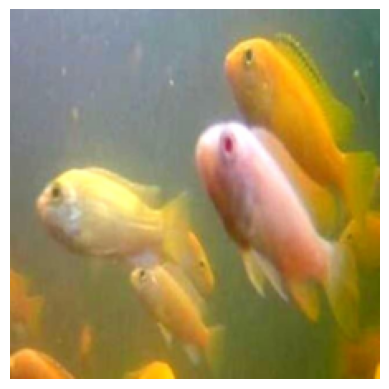

In [ ]:
# Define the transform: resize and convert to tensor
target_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),  # Converts [0, 255] range to [0.0, 1.0] and moves channel to the first dimension
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transform to the image
img_transformed = transform(img)

# Convert to shape (1, 3, 224, 224)
img_transformed = img_transformed.unsqueeze(0)  # Add a batch dimension

print(img_transformed.shape)  # Should print torch.Size([1, 3, 224, 224])

# Remove the batch dimension and convert to numpy array
viewIm = img_transformed.squeeze(0)
viewIm = viewIm.permute(1, 2, 0)  # Change the order to (224, 224, 3)

# Display the transformed image
plt.imshow(viewIm)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
keypoints = np.loadtxt("/content/DePoondF'i24_Train/Keypoints/frame122_jpg.rf.7d74cc9befdf8f75b7ad92faded636c2.txt", delimiter=',')
keypoints[:, 0] /= img.size[0]
keypoints[:, 1] /= img.size[1]
keypoints[:, 0] *= target_size[0]
keypoints[:, 1] *= target_size[1]

In [ ]:
keypoints

array([[130.0845 ,  33.21605],
       [144.8139 ,  27.60835],
       [209.29615,  67.26335],
       [175.9093 ,  74.0726 ],
       [162.48925,  94.1003 ],
       [203.077  ,  98.50645],
       [223.04345,  88.4926 ],
       [219.77025, 110.523  ],
       [213.8787 , 130.1503 ],
       [113.06365,  85.28835],
       [132.3756 ,  82.48415],
       [198.1672 , 117.733  ],
       [164.12585, 134.1557 ],
       [153.32415, 150.97915],
       [194.23915, 155.7857 ],
       [210.2779 , 144.16955],
       [211.58725, 173.8107 ],
       [212.8966 , 202.65035],
       [ 15.52215, 120.13645],
       [ 27.6332 , 111.32415],
       [ 91.4606 , 106.918  ],
       [ 62.98355, 124.14185],
       [ 58.7286 , 149.37685],
       [ 93.42445, 132.55375],
       [108.15385, 109.72185],
       [107.8266 , 133.35455],
       [108.15385, 154.98455],
       [ 73.458  , 162.19455],
       [ 80.33165, 160.993  ],
       [117.97345, 177.01495],
       [101.93505, 183.0234 ],
       [ 93.7517 , 194.63955],
       [

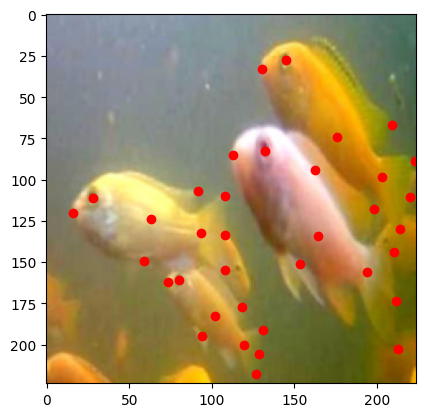

In [ ]:
plt.scatter(keypoints[:,0],keypoints[:,1],c='r')
plt.imshow(viewIm)
plt.show()

In [ ]:
outputs = model(img_transformed.to(device)).cpu().detach().numpy()

In [ ]:
outputs[0]

array([ 8.57757807e-01,  1.03653049e+00,  7.52139688e-01,  1.03032434e+00,
        6.96374416e-01,  9.22130883e-01,  6.97811961e-01,  1.06202042e+00,
        6.87332690e-01,  1.03882599e+00,  7.97898233e-01,  9.82707918e-01,
        7.83864975e-01,  9.57427919e-01,  6.51507676e-01,  1.01086044e+00,
        7.70424008e-01,  1.07760906e+00,  5.76469362e-01,  7.35409558e-01,
        5.85691750e-01,  7.11282909e-01,  4.64110970e-01,  6.52921677e-01,
        5.00736952e-01,  8.17589283e-01,  6.45378470e-01,  8.00397098e-01,
        6.30242050e-01,  7.53364921e-01,  5.26125669e-01,  7.17911303e-01,
        5.32498062e-01,  7.41922319e-01,  4.97268230e-01,  7.16827154e-01,
       -4.74023186e-02, -5.89443482e-02, -1.02572560e-01, -1.39167868e-02,
        3.77609208e-02, -8.00453573e-02, -3.41477282e-02, -1.97653696e-02,
       -9.87606496e-03, -6.01309277e-02, -3.21718380e-02, -9.17475075e-02,
       -1.28301792e-03, -2.75891349e-02, -4.86242771e-03, -7.28972405e-02,
       -1.76657289e-02, -

In [ ]:
y_coords = []
x_coords = []
for i in range(198):
    if i%2:
        y_coords.append(outputs[0][i]*615)
    else:
        x_coords.append(outputs[0][i]*615)

In [ ]:
len(x_coords)

99

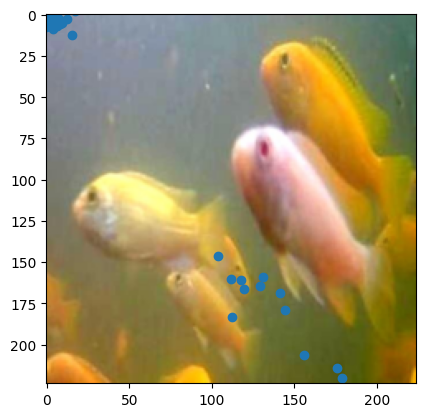

In [ ]:
plt.scatter(x_coords,y_coords)
plt.imshow(viewIm)

In [ ]:
flatten_keypoints = keypoints.flatten()

In [ ]:
ground_truth = np.zeros(198)
ground_truth[:len(flatten_keypoints)] = flatten_keypoints
ground_truth

array([130.0845 ,  33.21605, 144.8139 ,  27.60835, 209.29615,  67.26335,
       175.9093 ,  74.0726 , 162.48925,  94.1003 , 203.077  ,  98.50645,
       223.04345,  88.4926 , 219.77025, 110.523  , 213.8787 , 130.1503 ,
       113.06365,  85.28835, 132.3756 ,  82.48415, 198.1672 , 117.733  ,
       164.12585, 134.1557 , 153.32415, 150.97915, 194.23915, 155.7857 ,
       210.2779 , 144.16955, 211.58725, 173.8107 , 212.8966 , 202.65035,
        15.52215, 120.13645,  27.6332 , 111.32415,  91.4606 , 106.918  ,
        62.98355, 124.14185,  58.7286 , 149.37685,  93.42445, 132.55375,
       108.15385, 109.72185, 107.8266 , 133.35455, 108.15385, 154.98455,
        73.458  , 162.19455,  80.33165, 160.993  , 117.97345, 177.01495,
       101.93505, 183.0234 ,  93.7517 , 194.63955, 119.2828 , 200.24725,
       130.739  , 191.03455, 128.4479 , 205.45455, 126.8113 , 217.8715 ,
         0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     , 

In [ ]:
import torch
import torch.nn as nn

# Assuming flatten_keypoints and outputs are numpy arrays or PyTorch tensors
# Convert them to PyTorch tensors if they are not already
ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
outputs = torch.tensor(outputs, dtype=torch.float32)

# Normalize keypoints
ground_truth_normalized = ground_truth / 224

# Select the first 36 elements of outputs
outputs_subset = outputs[0]

# Ensure both tensors have the same shape
if ground_truth_normalized.shape != outputs_subset.shape:
    raise ValueError(f"Shape mismatch: {ground_truth_normalized.shape} and {outputs_subset.shape}")

# Define the loss function
criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()

# Calculate the loss
loss1 = criterion1(ground_truth_normalized, outputs_subset)
loss2 = criterion2(ground_truth_normalized, outputs_subset)

# Print the loss
print(f'MAE Loss: {loss1.item()}')
print(f'MSE Loss: {loss2.item()}')


MAE Loss: 0.1762104034423828
MSE Loss: 0.09661410748958588
